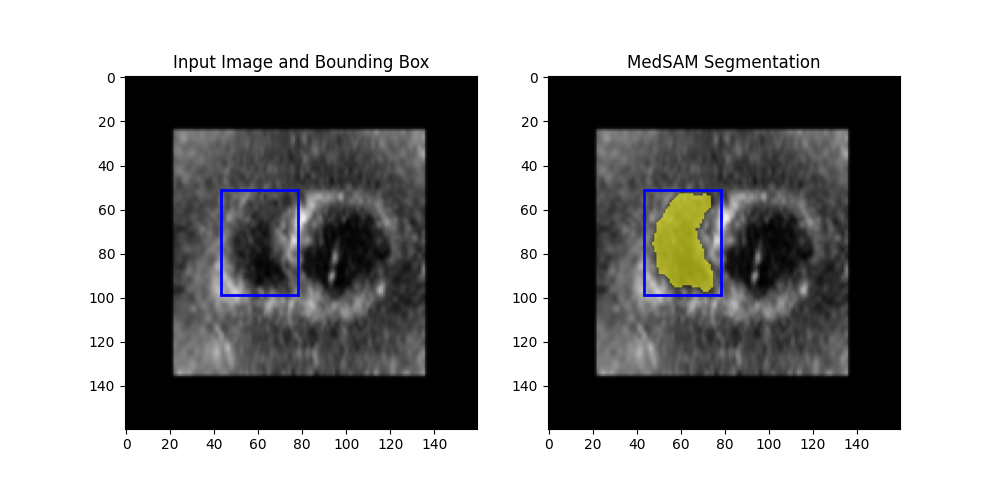

In [41]:
# -*- coding: utf-8 -*-

"""
usage example:
python MedSAM_Inference.py -i assets/img_demo.png -o ./ --box "[95,255,190,350]"

"""

# %% load environment
import numpy as np
import matplotlib.pyplot as plt
import os

join = os.path.join
import torch
from segment_anything import sam_model_registry
from skimage import io, transform
import torch.nn.functional as F
import argparse


# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251 / 255, 252 / 255, 30 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2)
    )


@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :]  # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed,  # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(),  # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings,  # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings,  # (B, 256, 64, 64)
        multimask_output=False,
    )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg


# %% load model and image
parser = argparse.ArgumentParser(
    description="run inference on testing set based on MedSAM"
)
parser.add_argument(
    "-i",
    "--data_path",
    type=str,
    default="assets/0083.png",
    help="path to the data folder",
)
parser.add_argument(
    "-o",
    "--seg_path",
    type=str,
    default="assets/",
    help="path to the segmentation folder",
)
parser.add_argument(
    "--box",
    type=str,
    default='[95, 255, 190, 350]',
    help="bounding box of the segmentation target",
)
parser.add_argument("--device", type=str, default="cuda:0", help="device")
parser.add_argument(
    "-chk",
    "--checkpoint",
    type=str,
    default="/data1/yisi/mywork/MedSAM/medsam_vit_b/medsam_vit_b.pth",
    help="path to the trained model",
)
# 手动设置参数
args = argparse.Namespace(
    data_path="assets/0083.png",
    seg_path="assets/",
    box="[43, 51, 78, 99]", #[350,255,230,180]
    device="cuda:0",
    checkpoint="/data1/yisi/mywork/MedSAM/medsam_vit_b/medsam_vit_b.pth"
)
device = args.device
medsam_model = sam_model_registry["vit_b"](checkpoint=args.checkpoint)
medsam_model = medsam_model.to(device)
medsam_model.eval()

img_np = io.imread(args.data_path)
if len(img_np.shape) == 2:
    img_3c = np.repeat(img_np[:, :, None], 3, axis=-1)
else:
    img_3c = img_np
H, W, _ = img_3c.shape
# %% image preprocessing
img_1024 = transform.resize(
    img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True
).astype(np.uint8)
img_1024 = (img_1024 - img_1024.min()) / np.clip(
    img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
)  # normalize to [0, 1], (H, W, 3)
# convert the shape to (3, H, W)
img_1024_tensor = (
    torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)
)

box_np = np.array([[int(x) for x in args.box[1:-1].split(',')]]) 
# transfer box_np t0 1024x1024 scale
box_1024 = box_np / np.array([W, H, W, H]) * 1024
with torch.no_grad():
    image_embedding = medsam_model.image_encoder(img_1024_tensor)  # (1, 256, 64, 64)

medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, H, W)
io.imsave(
    join(args.seg_path, "seg_" + os.path.basename(args.data_path)),
    medsam_seg*255,
    check_contrast=False,
)

# %% visualize results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_3c)
show_box(box_np[0], ax[0])
ax[0].set_title("Input Image and Bounding Box")
ax[1].imshow(img_3c)
show_mask(medsam_seg, ax[1])
show_box(box_np[0], ax[1])
ax[1].set_title("MedSAM Segmentation")
plt.show()


# 一次分割多个框图

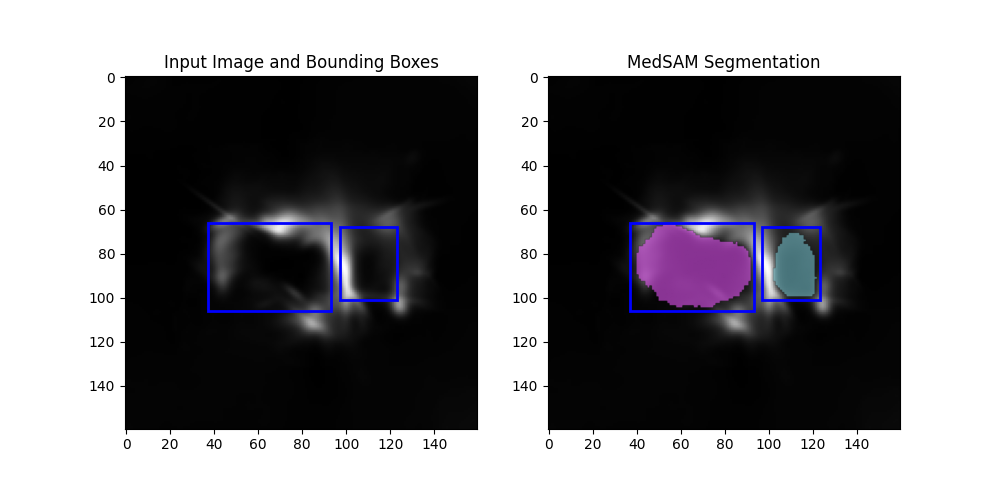

In [60]:
# -*- coding: utf-8 -*-

"""
usage example:
python MedSAM_Inference.py -i assets/img_demo.png -o ./ --box "[95,255,190,350]，[43,51,78,99]"  # 用逗号隔开不同的框
"""

# %% load environment
import numpy as np
import matplotlib.pyplot as plt
import os

join = os.path.join
import torch
from segment_anything import sam_model_registry
from skimage import io, transform
import torch.nn.functional as F
import argparse


# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251 / 255, 252 / 255, 30 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2)
    )


@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    medsam_segs = []  # 存储每个框的分割结果
    for b in box_1024:
        box_torch = torch.as_tensor(b, dtype=torch.float, device=img_embed.device).unsqueeze(0)  # (1, 4)
        
        sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
            points=None,
            boxes=box_torch,
            masks=None,
        )
        
        low_res_logits, _ = medsam_model.mask_decoder(
            image_embeddings=img_embed,  # (B, 256, 64, 64)
            image_pe=medsam_model.prompt_encoder.get_dense_pe(),  # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings,  # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings,  # (B, 256, 64, 64)
            multimask_output=False,
        )
        
        low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)
        low_res_pred = F.interpolate(
            low_res_pred,
            size=(H, W),
            mode="bilinear",
            align_corners=False,
        )  # (1, 1, H, W)
        
        # 将结果转为numpy并进行二值化
        low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (H, W)
        seg = (low_res_pred > 0.5).astype(np.uint8)
        
        medsam_segs.append(seg)
    
    return np.array(medsam_segs)


# %% load model and image
parser = argparse.ArgumentParser(
    description="run inference on testing set based on MedSAM"
)
parser.add_argument(
    "-i",
    "--data_path",
    type=str,
    default="assets/0089.png",
    help="path to the data folder",
)
parser.add_argument(
    "-o",
    "--seg_path",
    type=str,
    default="assets/",
    help="path to the segmentation folder",
)
parser.add_argument(
    "--box",
    type=str,
    default='[95, 255, 190, 350]，[43,51,78,99]',
    help="bounding box of the segmentation target, multiple boxes are separated by comma",
)
parser.add_argument("--device", type=str, default="cuda:0", help="device")
parser.add_argument(
    "-chk",
    "--checkpoint",
    type=str,
    default="/data1/yisi/mywork/MedSAM/medsam_vit_b/medsam_vit_b.pth",
    help="path to the trained model",
)
# 手动设置参数
args = argparse.Namespace(
    data_path="assets/slice_80_channel_12.png",
    seg_path="assets/",
    box="[37, 66, 93, 106],[97,68,123,101]",  # 添加多个框，用逗号隔开
    device="cuda:0",
    checkpoint="/data1/yisi/mywork/MedSAM/medsam_vit_b/medsam_vit_b.pth"
)
device = args.device
medsam_model = sam_model_registry["vit_b"](checkpoint=args.checkpoint)
medsam_model = medsam_model.to(device)
medsam_model.eval()

img_np = io.imread(args.data_path)
if len(img_np.shape) == 2:
    img_3c = np.repeat(img_np[:, :, None], 3, axis=-1)
else:
    img_3c = img_np
H, W, _ = img_3c.shape
# %% image preprocessing
img_1024 = transform.resize(
    img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True
).astype(np.uint8)
img_1024 = (img_1024 - img_1024.min()) / np.clip(
    img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
)  # normalize to [0, 1], (H, W, 3)
# convert the shape to (3, H, W)
img_1024_tensor = (
    torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)
)

# 解析多个框的字符串并清理掉额外的字符
box_str = args.box.replace("][", "],[").replace("[", "").replace("]", "")  # 清理字符
box_list = box_str.split(',')  # 分割成多个数字

# 将每4个数字组成一个框
box_np = np.array([list(map(int, box_list[i:i+4])) for i in range(0, len(box_list), 4)])

# transfer box_np to 1024x1024 scale
box_1024 = box_np / np.array([W, H, W, H]) * 1024
with torch.no_grad():
    image_embedding = medsam_model.image_encoder(img_1024_tensor)  # (1, 256, 64, 64)

medsam_segs = medsam_inference(medsam_model, image_embedding, box_1024, H, W)

# %% visualize results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_3c)
for box in box_np:
    show_box(box, ax[0])
ax[0].set_title("Input Image and Bounding Boxes")

ax[1].imshow(img_3c)
for i, box in enumerate(box_np):
    show_mask(medsam_segs[i], ax[1], random_color=True)  # 为每个框生成不同的颜色
    show_box(box, ax[1])
ax[1].set_title("MedSAM Segmentation")
plt.show()


# point inference

In [25]:
%matplotlib widget
from segment_anything import sam_model_registry
from os.path import join, isfile, basename
from os import getcwd
from matplotlib import pyplot as plt
from ipywidgets import interact, widgets
from torch.nn import functional as F
import cv2
import torch
import numpy as np
import gc
import SimpleITK as sitk
import numpy as np
from matplotlib import pyplot as plt

class PointPromptDemo:
    def __init__(self, model):
        self.model = model
        self.model.eval()
        self.image = None
        self.image_embeddings = None
        self.img_size = None


    def show_mask(self, mask, ax, random_color=False, alpha=0.95):
        if random_color:
            color = np.concatenate([np.random.random(3), np.array([alpha])], axis=0)
        else:
            color = np.array([251/255, 252/255, 30/255, alpha])
        h, w = mask.shape[-2:]
        mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
        ax.imshow(mask_image)

    @torch.no_grad()
    def infer(self, x, y):
        coords_1024 = np.array([[[
            x * 1024 / self.img_size[1],
            y * 1024 / self.img_size[0]
        ]]])
        coords_torch = torch.tensor(coords_1024, dtype=torch.float32).to(self.model.device)
        labels_torch = torch.tensor([[1]], dtype=torch.long).to(self.model.device)
        point_prompt = (coords_torch, labels_torch)

        sparse_embeddings, dense_embeddings = self.model.prompt_encoder(
            points = point_prompt,
            boxes = None,
            masks = None,
        )
        low_res_logits, _ = self.model.mask_decoder(
            image_embeddings=self.image_embeddings, # (B, 256, 64, 64)
            image_pe=self.model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
        )

        low_res_probs = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)
        low_res_pred = F.interpolate(
            low_res_probs,
            size = self.img_size,
            mode = 'bilinear',
            align_corners = False
        )
        low_res_pred = low_res_pred.detach().cpu().numpy().squeeze()

        seg = np.uint8(low_res_pred > 0.5)

        return seg

    def show(self, fig_size=5, alpha=0.95, scatter_size=10):

        assert self.image is not None, "Please set image first."
        seg = None
        fig, ax = plt.subplots(1, 1, figsize=(fig_size, fig_size))
        fig.canvas.header_visible = False
        fig.canvas.footer_visible = False
        fig.canvas.toolbar_visible = False
        fig.canvas.resizable = False

        plt.tight_layout()

        ax.imshow(self.image)
        ax.axis('off')

        def onclick(event):
            if event.inaxes == ax:
                x, y = float(event.xdata), float(event.ydata)
                with torch.no_grad():
                    ## rescale x, y from canvas size to 1024 x 1024
                    seg = self.infer(x, y)

                ax.clear()
                ax.imshow(self.image)
                ax.axis('off')
                ax.scatter(x, y, c='r', s=scatter_size)
                self.show_mask(seg, ax, random_color=False, alpha=alpha)

                gc.collect()

        fig.canvas.mpl_connect('button_press_event', onclick)
        plt.show()

        save_button = widgets.Button(description="save")
        def __on_save_button_clicked(b):
            plt.savefig("seg_result.png", bbox_inches='tight', pad_inches=0)
            if seg is not None:
                cv2.imwrite("seg.png", seg)
                print(f"Segmentation result saved to {getcwd()}")

        display(save_button)
        save_button.on_click(__on_save_button_clicked)

    def set_image(self, image):
        self.img_size = image.shape[:2]
        if len(image.shape) == 2:
            image = np.repeat(image[:,:,None], 3, -1)
        self.image = image
        image_preprocess = self.preprocess_image(self.image)
        with torch.no_grad():
            self.image_embeddings = self.model.image_encoder(image_preprocess)

    def preprocess_image(self, image):
        img_resize = cv2.resize(
            image,
            (1024, 1024),
            interpolation=cv2.INTER_CUBIC
        )
        # Resizing
        img_resize = (img_resize - img_resize.min()) / np.clip(img_resize.max() - img_resize.min(), a_min=1e-8, a_max=None) # normalize to [0, 1], (H, W, 3
        # convert the shape to (3, H, W)
        assert np.max(img_resize)<=1.0 and np.min(img_resize)>=0.0, 'image should be normalized to [0, 1]'
        img_tensor = torch.tensor(img_resize).float().permute(2, 0, 1).unsqueeze(0).to(self.model.device)

        return img_tensor


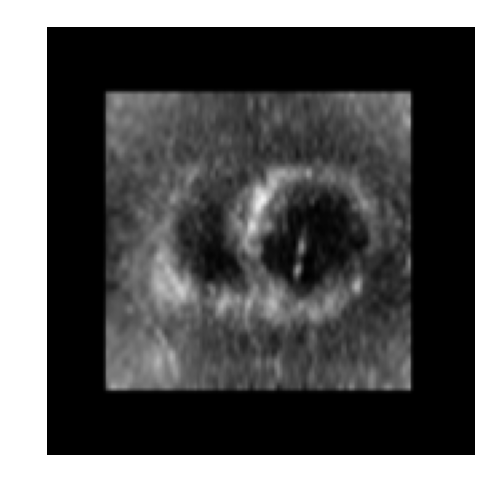

Button(description='save', style=ButtonStyle())

In [35]:
medsam_ckpt_path = "/data1/yisi/mywork/MedSAM/medsam_vit_b/medsam_point_prompt_flare22.pth"
device = "cuda:0"
medsam_model = sam_model_registry['vit_b'](checkpoint=medsam_ckpt_path)
medsam_model = medsam_model.to(device)
medsam_model.eval()
point_prompt_demo = PointPromptDemo(medsam_model)

img_path = "/data1/yisi/mywork/MedSAM/assets/0083.png"
img_np = io.imread(img_path)
point_prompt_demo.set_image(img_np)
point_prompt_demo.show()

In [56]:
import cv2
a = cv2.imread("/data1/yisi/mywork/MedSAM/assets/0089.png",-1)

In [57]:
a.shape

(160, 160)